# Projeto de Software Quântico  - Memória Associativa
## Parte 1 - Algoritmo de Grover

#### Imports

In [12]:
%pip install qiskit qiskit-aer
%pip install matplotlib
%pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# imports principais (circuito quântico, transpile/compilador, simulador quântico local, histograma, statevector para análise)
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

# imports para a matemática e visualização
import numpy as np
import matplotlib.pyplot as plt

#### Parâmetros Globais

In [14]:
n_qubits = 3              # padrão mínimo demonstrativo - chega a 8 estados
target_state = "101"      # força o oracle a lidar com padrões mistos e inverter fase em qubits diferentes
shots = 1024              # 2^10 - equiliíbro ideal entre estatística e custo computacional

#### Função base de circuito - cria um circuito novo sempre que precisar

In [15]:
def create_base_circuit(n):
    # cria um circuito quântico com n qubits e n bits clássicos para medição
    qc = QuantumCircuit(n, n) 
    return qc

    

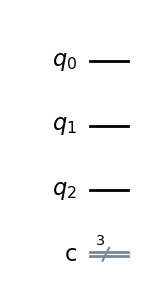

In [16]:
# teste de criação do circuito base
qc = create_base_circuit(n_qubits)
qc.draw("mpl")

### Superposição Uniforme

In [17]:
# aplicar a porta Hadamard em todos os qubits para criar superposição
def apply_hadamard_all(qc, n): 
    for i in range(n):  # loop para aplicar a porta Hadamard em cada qubit; i representa o índice do qubit 
        qc.h(i) # aplica a porta Hadamard no qubit i, colocando-o em superposição
    return qc # retorna o circuito atualizado com as portas Hadamard aplicadas a todos os qubits

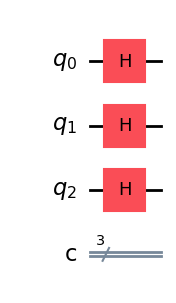

In [18]:
qc = create_base_circuit(n_qubits) 
qc = apply_hadamard_all(qc, n_qubits)

qc.draw("mpl")

### Oráculo - Inversão de fase

#### Propriedades desejadas:
##### 1. Usar portas quânticas reversíveis
##### 2. Alterar fases
##### 3. Marcar exatamente um subconjunto de dados

In [19]:
# o oráculo troca a fase do estado alvo, para que ele se destaque na interferência construtiva do algoritmo de Grover
# Toffoli gate é uma operação multi-qubit que inverte o estado do qubit alvo apenas quando todos os qubits de controle estão em estado |1> 
def apply_oracle(qc, target):
    n = len(target) 
    for i in range(n):
        if target[i] == '0':  # se o bit do estado alvo for 0, aplicamos uma porta X para inverter o qubit porque o controle da porta Toffoli é ativado quando os qubits estão em estado |1>
            qc.x(i) # aplica a porta X no qubit i para inverter seu estado, preparando-o para o controle da porta Toffoli
    qc.h(n-1)  # aplica a porta Hadamard no último qubit para preparar para a porta de controle
    qc.mcx(list(range(n-1)), n-1)  # aplica a porta Toffoli controlada por todos os qubits exceto o último
    qc.h(n-1)  # aplica a porta Hadamard novamente para restaurar o estado do último qubit
    for i in range(n):
        if target[i] == '0':  
            qc.x(i)
    return qc  


In [20]:
# teste do oráculo para verificar se ele inverte a fase do estado alvo corretamente
qc_test = create_base_circuit(n_qubits)
qc_test = apply_hadamard_all(qc_test, n_qubits)
qc_test = apply_oracle(qc_test, target_state)

state = Statevector.from_instruction(qc_test)
print(state)

Statevector([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j,
              0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
              0.35355339+0.j,  0.35355339+0.j],
            dims=(2, 2, 2))


### Difusão - Reflexão na média

In [21]:
# Diffusion operator (inversão sobre a média) para amplificar a probabilidade do estado alvo    
def apply_diffusion(qc, n):
    qc.h(range(n))  # aplica a porta Hadamard em todos os qubits para criar superposição
    qc.x(range(n))  # aplica a porta X em todos os qubits para inverter seus estados
    qc.h(n-1)       # aplica a porta Hadamard no último qubit para preparar para a porta de controle
    qc.mcx(list(range(n-1)), n-1)  # aplica a porta Toffoli controlada por todos os qubits exceto o último
    qc.h(n-1)       # aplica a porta Hadamard novamente para restaurar o estado do último qubit
    qc.x(range(n))  # aplica a porta X novamente para restaurar os estados originais dos qubits
    qc.h(range(n))  # aplica a porta Hadamard novamente para finalizar a inversão sobre a média
    return qc
# isso resulta em # D = H^{⊗n} X^{⊗n} MCZ X^{⊗n} H^{⊗n} onde ⊗ significa a aplicação da operação em todos os qubits, e MCZ é a porta de controle que inverte a fase do estado |11...1> (todos os qubits em estado |1>)

In [22]:
# teste do operador de difusão para verificar se ele amplifica a probabilidade do estado alvo corretamente
qc_test = create_base_circuit(n_qubits)
qc_test = apply_hadamard_all(qc_test, n_qubits)
qc_test = apply_oracle(qc_test, target_state)
qc_test = apply_diffusion(qc_test, n_qubits)

state = Statevector.from_instruction(qc_test)
print(state)

Statevector([-0.1767767 +0.j, -0.1767767 +0.j, -0.1767767 +0.j,
             -0.1767767 +0.j, -0.1767767 +0.j, -0.88388348+0.j,
             -0.1767767 +0.j, -0.1767767 +0.j],
            dims=(2, 2, 2))


### Iterações

In [23]:
# número ótimo de iterações r para maximizar a probabilidade de encontrar o estado alvo é aproximadamente π/4 * √N, onde N é o número total de estados possíveis (2^n_qubits)
N = 2**n_qubits
r = int(np.pi/4 * np.sqrt(N))

print("Espaço de busca N =", N)
print("Número ótimo de iterações r =", r)

Espaço de busca N = 8
Número ótimo de iterações r = 2


### Implementação do Algoritmo de Grover

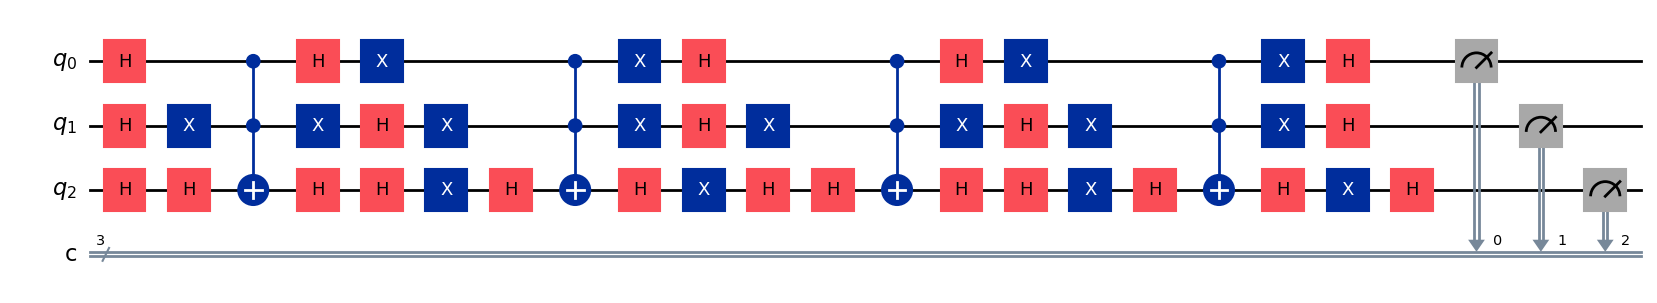

In [24]:
# construção completa
qc = create_base_circuit(n_qubits) # cria o circuito base com n qubits e n bits clássicos
qc = apply_hadamard_all(qc, n_qubits) # aplica a porta Hadamard em todos os qubits para criar superposição
for _ in range(r): # loop para aplicar o oráculo e o operador de difusão
    qc = apply_oracle(qc, target_state) # aplica o oráculo para inverter a fase do estado alvo
    qc = apply_diffusion(qc, n_qubits) # aplica o operador de difusão para amplificar a probabilidade do estado alvo

# medição 
qc.measure(range(n_qubits), range(n_qubits)) # mede todos os qubits e armazena os resultados nos bits clássicos correspondentes
qc.draw("mpl")

Contagem de resultados: {'101': 974, '110': 7, '100': 7, '000': 10, '111': 6, '001': 8, '010': 8, '011': 4}


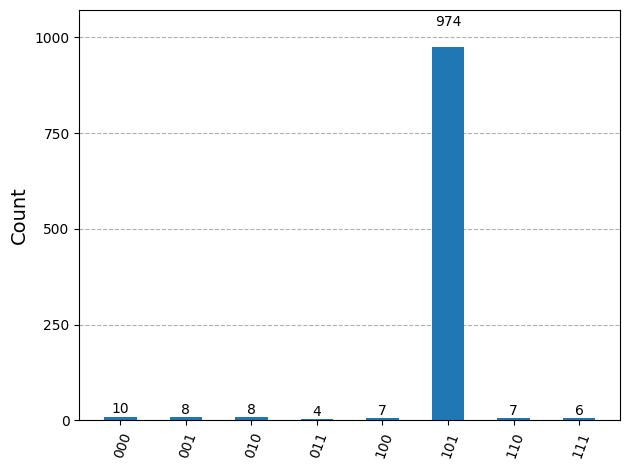

In [25]:
# execução no simulador local
simulator = Aer.get_backend('qasm_simulator') # seleciona o backend do simulador
compiled_qc = transpile(qc, simulator) # transpila o circuito para o formato do simulador

job = simulator.run(compiled_qc, shots=shots) # executa o circuito no simulador com o número de shots definido
result = job.result() # obtém os resultados da execução
counts = result.get_counts(compiled_qc) # obtém a contagem de cada resultado medido

print("Contagem de resultados:", counts)
plot_histogram(counts) 

In [ ]:
# função para executar o algoritmo de Grover com um número diferente de iterações e retornar os resultados 
def run_grover_iterations(num_iterations):
    
    qc = create_base_circuit(n_qubits) # Superposição inicial
    qc = apply_hadamard_all(qc, n_qubits) # Aplicar Grover num_iterations vezes
    for _ in range(num_iterations):
        qc = apply_oracle(qc, target_state)
        qc = apply_diffusion(qc, n_qubits)
    
    # Medição
    qc.measure(range(n_qubits), range(n_qubits))
    
    # Execução
    simulator = Aer.get_backend('qasm_simulator')
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    
    return result.get_counts()

# Grover não converge, cada iteração adiciona rotação e ao passar do ponto ótimo, a probabilidade do estado alvo começa a diminuir
# então é importante escolher o número certo de iterações para maximizar a probabilidade de encontrar o estado alvo.


In [29]:
for k in [r-1, r, r+1]:
    counts = run_grover_iterations(k)
    print(f"\nIterações = {k}")
    print(counts)
    plot_histogram(counts)


Iterações = 1
{'101': 830, '011': 34, '111': 34, '001': 21, '110': 31, '000': 25, '010': 27, '100': 22}

Iterações = 2
{'101': 960, '000': 5, '110': 15, '011': 6, '001': 11, '111': 5, '010': 16, '100': 6}

Iterações = 3
{'101': 340, '010': 102, '111': 97, '001': 97, '000': 98, '011': 104, '100': 84, '110': 102}
